# Датасет VOC2028

## Общий блок импорта

In [1]:
# Предварительная установка пакетов (для Colab)
#!pip install torchinfo ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import torch
import matplotlib.image as img
import matplotlib.pyplot as plt
import matplotlib

import typing
import xml.etree.ElementTree as ET

import os
from tqdm import tqdm
import json
import random

from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image

import numpy as np
import torchvision.transforms.functional as F

#from ultralytics import YOLO
from PIL import Image
import cv2

from torchinfo import summary

from torchvision.ops import box_convert

%matplotlib inline

## Выбор места исполнения (локально, Google Colab, ...)

In [2]:
# Устанавливаем путь до датасета

# Локально
ds_path = '/home/vovk/SberUniversity/DS_from_03_10_2022/PM_Group_AN/FinalProj/HelmetDetection/VOC2028/'

# Colab
# from google.colab import drive
# drive.mount('/content/drive')

# ds_path = '/content/drive/MyDrive/SberUniversity/PM_DS14AN/Fin/HelmetDetection/VOC2028/'

## Подготовка и анализ датасета

### Чтение изображений и меток

#### Просмотр датасета

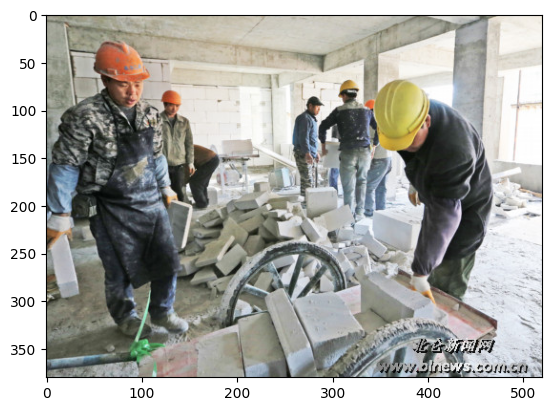

In [3]:
# Проверка путей и наличия датасета
I0 = img.imread(ds_path+'JPEGImages/000097.jpg', 'jpg')
plt.imshow(I0)
plt.show()

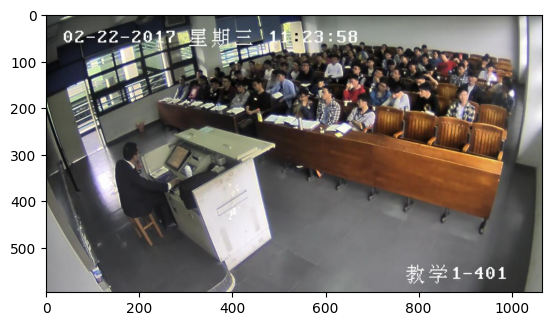

In [4]:
I1 = img.imread(ds_path+'JPEGImages/PartA_00025.jpg', 'jpg')
plt.imshow(I1)
plt.show()

Датасет состоит из нескольких частей, разделяемых по диапазону имён:

1. xxxxxx (6 цифр) - часть датасета преимущественно с касками на голове
2. part2_xxxxxx - также преимущественно люди в касках
3. PartA_xxxxx - фотографии security-камеры в одной учебной аудитории (без касок)
4. PartB_xxxxx - фотографии людей без касок в произвольных местах (преимущественно различные учебные помещения)

#### Парсинг данных

In [30]:
def parse_data_file(annot_file_path: str):
    """Parsing xml annotations of PASCAL VOC format.
    Created especially for VOC2028 dataset. Parse two type of annotations:
    hat for helmet, person for head.

    Args:
        annot_file_path (str): full path to file

    Returns:
        dict: dictionary with parsed data. Contain:
                file_name - short file name(no path) without extension,
                image_wh - image size in format [image_width, image_height],
                helmet_count - count of elements of class hat(->helmet), described in xml file
                person_count - count of elements of class person(->head), described in xml file,
                other_count - count of elements of other classes, described in xml file,
                other_name - list of filenames of other classes, described in xml file,
                helmet_bndbox - list of bounding boxes of elements of class hat(helmet)
                                in format [xmin, ymin, xmax, ymax] in pixels,
                person_bndbox - list of bounding boxes of elements of class person(head)
                                in format [xmin, ymin, xmax, ymax] in pixels,
    """

    image_width, image_height = 0, 0
    person_bnd, helmet_bnd = [], []
    num_person, num_helmet, num_other = 0, 0, 0
    other_name = set()

    root = ET.parse(annot_file_path).getroot()
    for el in root:
        if el.tag == 'size': # collect size
            for subel in el:
                if subel.tag == 'width':
                    image_width = int(subel.text)
                if subel.tag == 'height':
                    image_height = int(subel.text)
        if el.tag == 'object':
            annot_type = ''
            xmin, ymin, xmax, ymax = -1, -1, -1, -1
            for subel in el:
                if subel.tag == 'name':
                   annot_type = subel.text
                if subel.tag == 'bndbox':
                    for bnd in subel:
                        if bnd.tag == 'xmin':
                            xmin = int(bnd.text)
                        elif bnd.tag == 'ymin':
                            ymin = int(bnd.text)
                        elif bnd.tag == 'xmax':
                            xmax = int(bnd.text)
                        elif bnd.tag == 'ymax':
                            ymax = int(bnd.text)
                    if annot_type == 'person':
                        person_bnd.append([xmin, ymin, xmax, ymax])
                        num_person += 1
                    elif annot_type in ['helmet', 'hat'] :
                        helmet_bnd.append([xmin, ymin, xmax, ymax])
                        num_helmet += 1
                    else:
                        num_other += 1
                        other_name.add(annot_type)
    
    res = dict(file_name=os.path.split(annot_file_path)[1][:-4],
               image_wh=[image_width, image_height],
               helmet_count=num_helmet,
               person_count=num_person,
               other_count=num_other,
               other_name=list(other_name),
               helmet_bndbox=helmet_bnd,
               person_bndbox=person_bnd,
               )
    return res

In [6]:
# При первом обращении может выполняться долго. Потом, видимо, кэшируется и выполняется быстро.
other_class_names = set()
other_class_file_name = []

for f in tqdm(os.listdir(ds_path + 'Annotations/')):
    file_data = parse_data_file(annot_file_path=ds_path+'Annotations/'+f)
    other_class_names.update(file_data['other_name'])
    if file_data['other_count'] > 0:
        if file_data['other_name'][0] == 'dog':
            other_class_file_name.append(file_data['file_name'])


100%|██████████| 7581/7581 [00:03<00:00, 2395.43it/s]


In [7]:
other_class_file_name

['000377']

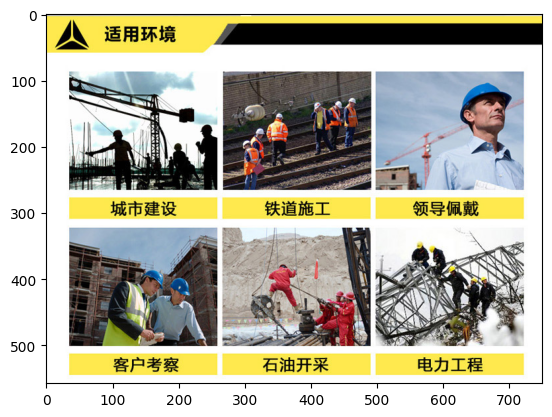

In [8]:
Idog = img.imread(ds_path+'JPEGImages/000377.jpg', 'jpg')
plt.imshow(Idog)
plt.show()

Файл с такой разметкой один -> просто проигнорируем.

In [9]:
# Собираем данные о метках в один список.
data = []
for f in tqdm(os.listdir(ds_path + 'Annotations/')):
    data.append(parse_data_file(annot_file_path=ds_path+'Annotations/'+f))

100%|██████████| 7581/7581 [00:01<00:00, 4411.55it/s]


In [10]:
# Запишем всю информацию в json файл, чтобы каждый раз не гонять по файлам
with open(ds_path + "data.json", "w") as f:
    json.dump(data, f)

In [21]:
# Считывание данных из файла
with open(ds_path + "data.json", 'r') as f:
    data = json.load(f)

#### Составление списка файлов для тренировочной и валидационной выборок

In [22]:
# Count total amount of labels
helmet_count, person_count = 0, 0
for el in data:
    helmet_count += el['helmet_count']
    person_count += el['person_count']
print(f'{helmet_count=}, {person_count=}')
print(f'{helmet_count*0.2=}, {person_count*0.2=}')

helmet_count=9058, person_count=111710
helmet_count*0.2=1811.6000000000001, person_count*0.2=22342.0


Значит в валидационной выборке (20% от общего количества) суммарно должно быть около 22342 объекта класса head (person) и 1811 объектов класа helmet (hat). В тренировочной выборке тогда должно быть 87368 объектов класса head и 7247 объекта класса helmet.

Подберём произвольным образом нужное количество объектов. Начнём с составления валидационной вырборки, всё остальное, очевидно, будет в тренировочной.

In [13]:
val_helmet_count, val_head_count = 1811, 22342 # количество объектов, которое надо набрать в валидационной выборке

In [23]:
# get lists of files with only helmet, only head and both class presented
helmet_lst, head_lst, cross_lst, full_lst = [], [], [], []
cross_count_helmet, cross_count_head, helm_count, head_count = 0, 0, 0, 0
for el in data:
    full_lst.append(el['file_name'])
    if el['helmet_count'] and el['person_count']:
        cross_lst.append([el['file_name'], el['helmet_count'], el['person_count']])
        cross_count_helmet += el['helmet_count']
        cross_count_head += el['person_count']
    elif el['helmet_count'] and not (el['person_count']):
        helmet_lst.append([el['file_name'], el['helmet_count'], el['person_count']])
        helm_count += el['helmet_count']
    elif not (el['helmet_count']) and el['person_count']:
        head_lst.append([el['file_name'], el['helmet_count'], el['person_count']])
        head_count += el['person_count']
print(len(cross_lst), len(helmet_lst), len(head_lst), len(cross_lst) + len(helmet_lst) + len(head_lst))
print(cross_count_helmet, cross_count_head, helm_count, head_count)

434 2788 4369 7591
2311 1457 6747 110253


In [24]:
# Определяем долю элементов класса helmet для выбора из разных списков
print(cross_count_helmet/helmet_count, helm_count/helmet_count) # из списка с пересечениями cross_lst берём 25% helmet, остальное из списка без пересечений head_lst
print(val_helmet_count*0.25, val_helmet_count*0.75) # набираем 452 объекта из списка пересечений cross_lst, 1359 - из списка helmet_lst (итого 1811 элементов - валидационная выборка).
# После набора класса helmet для валидации, недостающее количество элементов класса head добираем из списка элементов класса head без пересечений (head_lst)


0.2551335835725326 0.7448664164274674
452.75 1358.25


In [25]:
random.seed(25032023) # для воспроизводимости
random.shuffle(cross_lst)
random.shuffle(helmet_lst)
n, n_head = 0, 0
idx = 0
helmet_valid = []
while n < 452: # необходимое количество объектов helmet из cross_lst
    n += cross_lst[idx][1]
    n_head += cross_lst[idx][2]
    helmet_valid.append(cross_lst[idx][0])
    idx += 1
print(f'{n=}, {idx=}, {len(helmet_valid)=}')

idx = 0
while n <= val_helmet_count: # необходимое количество объектов helmet из helmet_lst
    n += helmet_lst[idx][1]
    n_head += helmet_lst[idx][2]
    helmet_valid.append(helmet_lst[idx][0])
    idx += 1
print(f'{n=}, {idx=}, {len(helmet_valid)=}, {n_head=}')

n=452, idx=102, len(helmet_valid)=102
n=1812, idx=605, len(helmet_valid)=707, n_head=290


Получилось всего на 1 элемент больше, чем планировалось. Нормально, оставляем так.

Теперь добираем элементы класса head до *val_head_count* = 22342.

In [26]:
random.shuffle(head_lst)
idx = 0
while n_head <= val_head_count: # необходимое количество объектов head из head_lst
    n_head += head_lst[idx][2]
    helmet_valid.append(head_lst[idx][0])
    idx += 1
print(f'{n=}, {idx=}, {len(helmet_valid)=}, {n_head=}')

n=1812, idx=863, len(helmet_valid)=1570, n_head=22349


Элементов класса *head* получилось на 7 больше запланированного. По сравнению с 22000 несущественно => оставляем так

In [27]:
# Сформированный список имен файлов для валидационной выборки - helmet_valid
# Создадим список файлов для тренировки через разницу множеств
helmet_train = list(set(full_lst).difference(set(helmet_valid)))

print(len(helmet_train), len(helmet_valid)) # Проверяем, что не потеряли файлы.

6021 1570


Сохраним (сериализуем) данные списки в json формате для дальнейшего использования.

In [80]:
with open(ds_path + "helmet_valid_filenames.json", "w") as f:
    json.dump(helmet_valid, f)

with open(ds_path + "helmet_train_filenames.json", "w") as f:
    json.dump(helmet_train, f)

Загрузка происходит также просто.

In [29]:
# Загрузка и преобразовывание обратно к списку
with open(ds_path + "helmet_valid_filenames.json", 'r') as f:
    helmet_valid = json.load(f)

with open(ds_path + "helmet_train_filenames.json", 'r') as f:
    helmet_train = json.load(f)